In [1]:
import numpy as np
from numpy.random import multinomial
import matplotlib.pyplot as plt
import warnings
from __future__ import division
import seaborn as sns
from scipy.stats import bernoulli, beta, binom
%matplotlib inline

In [2]:
def policy(params, method):
    """
    
    1. policy to determine which machine to select
    2. returns 0 or 1
    3. inputs (a1,a2,b1,b2) should be integers
    4. method should be either exploitation, exploration or proportion
    
    """
    
    if method == 'exploit':
        return np.argmax([float(a)/(a+b) for (a,b) in params])
    elif method == 'explore':
        k = len(params)
        return np.argmax(multinomial(1,np.repeat(float(1)/k,k)))
    elif method == 'thompson':
        return np.argmax([beta.rvs(a,b) for (a,b) in params])
    

In [3]:
def thompson_sampler(method, N, K, true_theta):
    """
    Implement Thompson Sampler
    
    Parameters
    -----
    
    method: exploit, explore, thompson
    N: number of iterations of the sampler
    K: number of machine
    
    Returns
    -----
    
    machine: array that holds the winning machine at each iteration
    sum(reward): the total reward
    theta: vector of parameters for each machine
    regret: vector of "rewards" if the machine with the maximum theta was always chosen
    
    """
    
    # remove numpy warnings for indexing with non-integers
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        machine = np.empty(N)
        reward = np.empty(N)
        
        regret = np.zeros(N)
        theta = np.ones(2*K).reshape(K,2) # prior is beta(1,1) for each machine

        for t in range(N):

            machine[t] = policy(theta, method)

            # sample reward using true probability
            reward_theta = true_theta[machine[t]]

            reward[t] = bernoulli.rvs(reward_theta)
            regret[t] = bernoulli.rvs(max(true_theta))

            if reward[t] == 1:
                theta[machine[t]][0] += 1 
            else:
                theta[machine[t]][1] += 1
            
        return machine, reward, theta, regret

In [4]:
def epsilon_greedy(epsilon, N, K, true_theta):
    
    #set up parameters
    true_best_machine = np.argmax(true_theta)
    theta = np.ones(2*K).reshape(K,2) # prior is beta(1,1) for each machine
    reward = np.zeros(N)
    regret = np.zeros(N)
    machine = np.empty(N)
    
    #Post first play
    for t in range(N):
        
        #Generate an epsilon decision
        epsilon_decision = bernoulli.rvs(epsilon)
        
        #If epsilon decision is 1, explore
        if(epsilon_decision==1):
            #Choose a machine randomly
            machine[t] = policy(theta, 'explore')
            #determine reward
            reward[t] = bernoulli.rvs(true_theta[int(machine[t])])
            #update theta
            if (reward[t]==1):
                theta[int(machine[t])][0] += 1
            else:
                theta[int(machine[t])][1] += 1   

    
        #If epsilon is 0, exploit best machine    
        else:
            #Choose machine with highest expected value
            machine[t] = policy(theta, 'exploit')
            #determine reward
            reward[t] = bernoulli.rvs(true_theta[int(machine[t])])
            #update theta
            if (reward[t]==1):
                theta[int(machine[t])][0] += 1
            else:
                theta[int(machine[t])][1] += 1   
        #update regret
        regret[t] = bernoulli.rvs(max(true_theta))
            
    
    return machine, reward, theta, regret


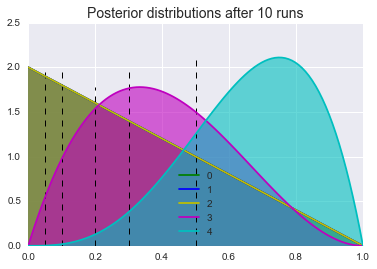

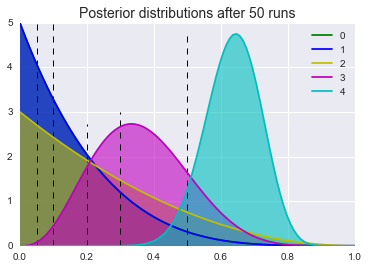

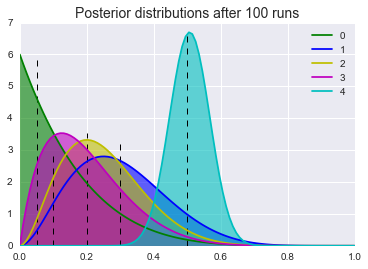

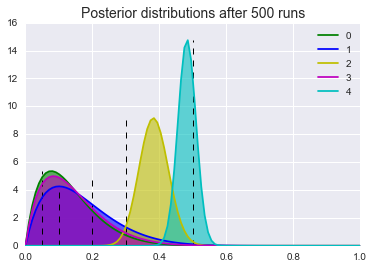

In [5]:
xvals = np.linspace(0,1,100)
f = lambda x: beta.pdf(x, param[0], param[1])

np.random.seed(121)
N = [10,50,100,500] # number of iterations
K = 5 # number of machines

xvals = np.linspace(0,1,100)
colors = ["g","b","y","m","c"]
true_theta = np.array([0.05,0.1,0.3,0.2,0.5])

for num in N:
    
    machines, R, theta, max_regret = thompson_sampler('thompson', num, K, true_theta)
    
    for e, param in enumerate(theta):
        
        f = lambda x: beta.pdf(x, param[0], param[1])
        
        plt.title("Posterior distributions after {} runs".format(num), size=14)
        plt.plot(xvals, f(xvals), color = colors[e], label = e)
        plt.vlines(true_theta[e],ymin=0,ymax=max(f(xvals)),linewidth=1,linestyle='--')
        plt.fill_between(xvals,f(xvals), alpha=0.6, color = colors[e])
        plt.legend(loc='best')
        
        
    plt.show()

In [6]:
N = 1000
K = 5
explore = thompson_sampler('explore', N, K, true_theta)
exploit = thompson_sampler('exploit', N, K, true_theta)
thompson = thompson_sampler('thompson', N, K, true_theta)
egreedy = epsilon_greedy(0.1, N, K, true_theta)

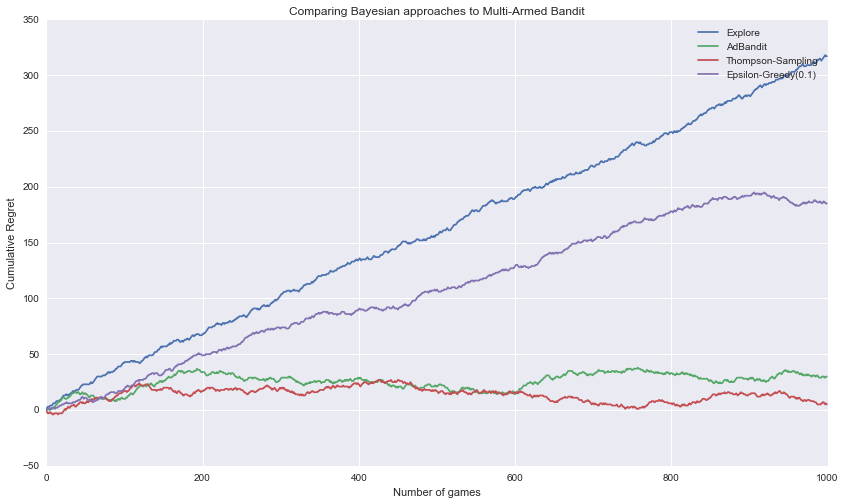

In [13]:
plt.figure(figsize=(14,8))
plt.title("Comparing Bayesian approaches to Multi-Armed Bandit")
plt.ylabel("Cumulative Regret")
plt.xlabel("Number of games")
plt.plot(np.cumsum(explore[3] - explore[1]))
plt.plot(np.cumsum(exploit[3] - exploit[1]))
plt.plot(np.cumsum(thompson[3] - thompson[1]))
plt.plot(np.cumsum(egreedy[3] - egreedy[1]))
plt.legend(['Explore','AdBandit','Thompson-Sampling', 'Epsilon-Greedy(0.1)'])
plt.show()

In [8]:
"""
UCB1 Algorithm
"""

N = 1000
K = 5
machine_reward = true_theta

machine_list = np.array(range(K))
r = np.zeros(K)
n = np.ones(K)
mu = r/n

machine_played = np.zeros(K*(N-K)).reshape((N-K),K)
machine_wins = np.zeros(K*(N-K)).reshape((N-K),K)
regret = np.zeros(N-K)

for t in range(K,N):

    machine = np.argmax(mu + np.sqrt(2*np.log(t)/n))  

    r[machine] += bernoulli.rvs(machine_reward[machine])
    n[machine] += 1
    
    machine_played[t-K] = n
    machine_wins[t-K] = r
    
    regret[t-K] += bernoulli.rvs(max(machine_reward))
    
    mu[machine] = r[machine]/n[machine]

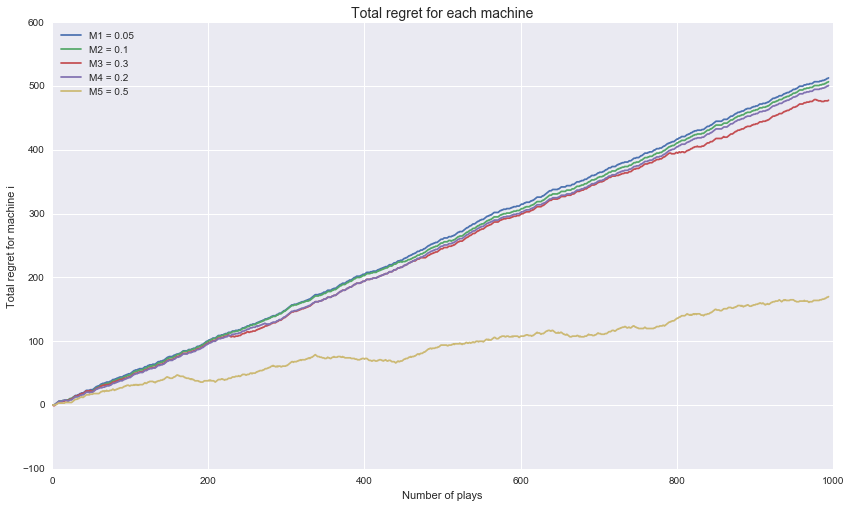

In [9]:
plot_regret = (np.cumsum(regret) - machine_wins.T).T
plt.figure(figsize=(14,8))
plt.title("Total regret for each machine",size=14)
plt.plot(plot_regret)
plt.legend(['M1 = {}'.format(machine_reward[0]),
            'M2 = {}'.format(machine_reward[1]),
            'M3 = {}'.format(machine_reward[2]),
            'M4 = {}'.format(machine_reward[3]),
            'M5 = {}'.format(machine_reward[4])],
          loc='best')
plt.ylabel("Total regret for machine i")
plt.xlabel("Number of plays")
            
pass

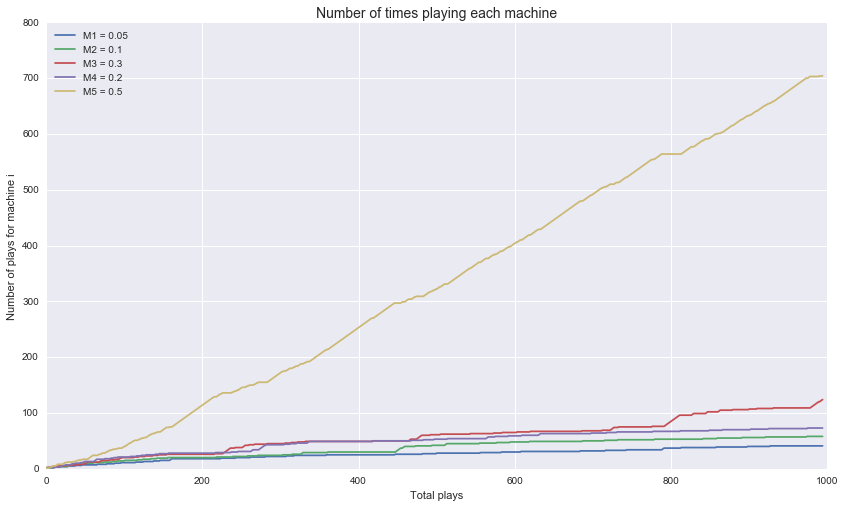

In [10]:
plt.figure(figsize=(14,8))
plt.title("Number of times playing each machine",size=14)
plt.plot(machine_played)
plt.legend(['M1 = {}'.format(machine_reward[0]),
            'M2 = {}'.format(machine_reward[1]),
            'M3 = {}'.format(machine_reward[2]),
            'M4 = {}'.format(machine_reward[3]),
            'M5 = {}'.format(machine_reward[4])],
          loc='best')
plt.ylabel("Number of plays for machine i")
plt.xlabel("Total plays")
            
pass

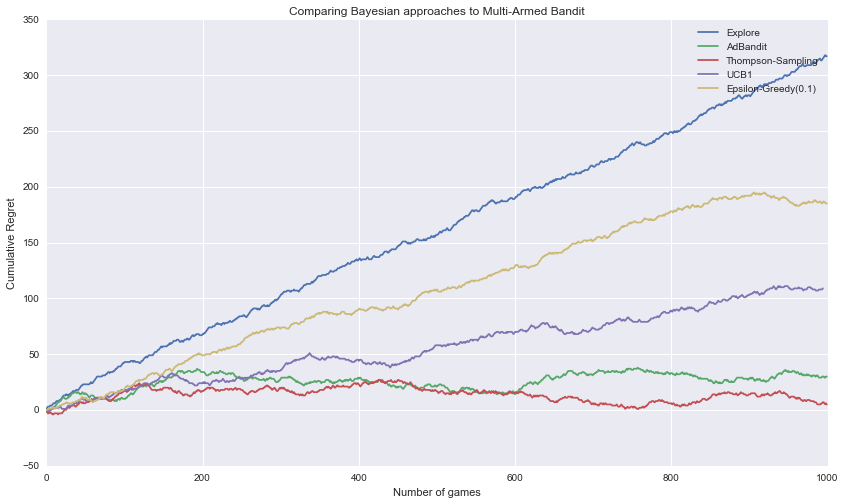

In [14]:
plt.figure(figsize=(14,8))
plt.title("Comparing Bayesian approaches to Multi-Armed Bandit")
plt.ylabel("Cumulative Regret")
plt.xlabel("Number of games")
plt.plot(np.cumsum(explore[3] - explore[1]))
plt.plot(np.cumsum(exploit[3] - exploit[1]))
plt.plot(np.cumsum(thompson[3] - thompson[1]))
plt.plot(np.cumsum(regret) - np.sum(machine_wins,axis=1))
plt.plot(np.cumsum(egreedy[3] - egreedy[1]))
plt.legend(['Explore','AdBandit','Thompson-Sampling','UCB1', 'Epsilon-Greedy(0.1)'])
plt.show()